<a href="https://colab.research.google.com/github/Alsuyav/Image_classification/blob/main/image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Классификация изображений
200 классов

~ 5000 объектов

Структура датасета -- есть директории train/ и val/, в которых лежат обучающие и валидационные данные. В train/ и val/ лежат директориии, соответствующие классам изображений, в которых лежат, собственно, сами изображения.

Задачи:

1) Добиться accuracy на валидации не менее 0.44 без использования предобученных моделей и ресайза картинок

2) Добиться accuracy на валидации не менее 0.84 с использованием предобученных моделей и ресайза картинок

__Советы и указания__:
 - Наверняка вам потребуется много гуглить о классификации и о том, как заставить её работать. Это нормально, все гуглят. Но не забывайте, что нужно быть готовым за скатанный код отвечать :)
 - Используйте аугментации. Для этого пользуйтесь модулем `torchvision.transforms` или библиотекой [albumentations](https://github.com/albumentations-team/albumentations)
 - Можно обучать с нуля или файнтюнить (в зависимости от задания) модели из `torchvision`.
 - Рекомендуем написать вам сначала класс-датасет (или воспользоваться классом `ImageFolder`), который возвращает картинки и соответствующие им классы, а затем функции для трейна по шаблонам ниже. Однако делать это мы не заставляем. Если вам так неудобно, то можете писать код в удобном стиле. Однако учтите, что чрезмерное изменение нижеперечисленных шаблонов увеличит количество вопросов к вашему коду и повысит вероятность вызова на защиту :)
 - Валидируйте. Трекайте ошибки как можно раньше, чтобы не тратить время впустую.
 - Чтобы быстро отладить код, пробуйте обучаться на маленькой части датасета (скажем, 5-10 картинок просто чтобы убедиться что код запускается). Когда вы поняли, что смогли всё отдебажить, переходите обучению по всему датасету
 - На каждый запуск делайте ровно одно изменение в модели/аугментации/оптимайзере, чтобы понять, что и как влияет на результат.
 - Фиксируйте random seed.
 - Начинайте с простых моделей и постепенно переходите к сложным. Обучение лёгких моделей экономит много времени.
 - Ставьте расписание на learning rate. Уменьшайте его, когда лосс на валидации перестаёт убывать.
 - Советуем использовать GPU. Если у вас его нет, используйте google colab. Если вам неудобно его использовать на постоянной основе, напишите и отладьте весь код локально на CPU, а затем запустите уже написанный ноутбук в колабе. Авторское решение задания достигает требуемой точности в колабе за 15 минут обучения.

**Что поможет сделать на 10 из 10 (одно задание - 5 баллов)**

1. Использовать все возможные методы оптимизации и эксперемнтировать с ними.
2. Подбор learning rate. Пример из прошлого семинара как это делать: [Как найти lr](https://pytorch-lightning.readthedocs.io/en/1.4.5/advanced/lr_finder.html)

```
  trainer = pl.Trainer(accelerator="gpu", max_epochs=2, auto_lr_find=True)

  trainer.tune(module, train_dataloader, eval_dataloader)

  trainer.fit(module, train_dataloader, eval_dataloader))
```



3. Аугментация данных. [Документация (полезная)](https://pytorch.org/vision/main/transforms.html), а также [библиотека albumentation](https://towardsdatascience.com/getting-started-with-albumentation-winning-deep-learning-image-augmentation-technique-in-pytorch-47aaba0ee3f8)
4. Подбор архитектуры модели.
5. Можно написать модель руками свою в YourNet, а можно импортировать не предобученную сетку известной архитектуры из модуля torchvision.models. Один из способов как можно сделать:

  * `torchvision.models.resnet18(pretrained=False, num_classes=200).to(device)`
  * Документация по возможным моделям и как их можно брать: [Документация (полезная)](https://pytorch.org/vision/stable/models.html)
6. Правильно нормализовывать данные при создании, пример [тык, но тут и в целом гайд от и до](https://www.pluralsight.com/guides/image-classification-with-pytorch)
7. Model Checkpointing. Сохраняйте свой прогресс (модели), чтобы когда что-то пойдет не так вы сможете начать с этого места или просто воспроизвести свои результаты модели, которые обучали.
 * Пример как можно с wandb тут: [Сохраняем лучшие модели в wandb](https://docs.wandb.ai/guides/integrations/lightning)
 * По простому можно так: [Сохраняем модели в pytorch дока](https://pytorch.org/tutorials/beginner/saving_loading_models.html)

## Загрузка, установка и импорт

In [1]:
%%capture
!pip install wandb
!pip3 install pytorch_lightning torchmetrics
!pip install -U albumentations
!wget https://www.dropbox.com/s/33l8lp62rmvtx40/dataset.zip?dl=1 -O dataset.zip && unzip -q dataset.zip

In [9]:
import math
import os
import random
import sys
import glob
import cv2

import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
from pandas.core.common import flatten
import numpy as np
import pytorch_lightning as pl
import torch
import torchvision
import torchvision.transforms as transforms
from PIL import Image
from pytorch_lightning.loggers import WandbLogger
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torchmetrics.functional import accuracy
from torchvision.datasets import ImageFolder
from tqdm import tqdm

In [3]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

d9d21848f5fce2d4dbd9b48636e1c1400beeeb94

In [10]:
def seed_everything(seed):
    # Фискирует максимум сидов
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(123456)

## Подготовка данных

In [12]:
# пути до обучающей и валидационной выборок
train_path = "/content/dataset/dataset/train"
val_path = "/content/dataset/dataset/val"

# списки путей до обучающих и тестовых картинок
train_paths = []
val_paths = []
# список классов
classes = []

# заполнение списков train_paths и classes
for data_path in glob.glob(train_path + '/*'):
    classes.append(data_path.split('/')[-1])
    train_paths.append(glob.glob(data_path + '/*'))
train_paths = list(flatten(train_paths))

# перемешивание обучающих картинок
random.shuffle(train_paths)

# заполнение списка val_paths
for data_path in glob.glob(val_path + '/*'):
    val_paths.append(glob.glob(data_path + '/*'))
val_paths = list(flatten(val_paths))

small_train_paths = train_paths[int(0.9*len(train_paths)):]


print("Train size: {}\nSmall_train size: {}\nValid size: {}".format(len(train_paths), len(small_train_paths), len(val_paths)))

Train size: 100000
Small train size: 10000
Valid size: 10000


In [16]:
# словари для классов - для сопоставления классов с индексами и индексами с классами
idx_to_class = {i:j for i, j in enumerate(classes)}
class_to_idx = {value:key for key,value in idx_to_class.items()}

In [46]:
# класс для данных
class OurDataset(Dataset):
    def __init__(self, image_paths, transform=False):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_filepath = self.image_paths[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        label = image_filepath.split('/')[-2]
        label = class_to_idx[label]
        if self.transform is not None:
            image = self.transform(image=image)["image"]

        return image, label

In [51]:
# обработка
train_transform = A.Compose(
    [
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=360, p=0.5),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.4),
        A.RandomBrightnessContrast(p=0.4),
        A.MultiplicativeNoise(multiplier=[0.5,2], per_channel=True, p=0.1),
        A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.4),
        A.RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.4),
        A.Normalize(mean=(0.544268535904948, 0.5078093085177952, 0.4505041277235243), std=(0.260139962956694, 0.2563979034887267, 0.25556574095234724)),
        ToTensorV2(),
    ]
)
val_transform = A.Compose(
    [
        A.Normalize(mean=(0.544268535904948, 0.5078093085177952, 0.4505041277235243), std=(0.260139962956694, 0.2563979034887267, 0.25556574095234724)),
        ToTensorV2()
    ]
)

train_dataset = OurDataset(train_paths, train_transform)
small_train_dataset = OurDataset(small_train_paths, train_transform)
val_dataset = OurDataset(val_paths, val_transform)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
small_train_dataloader = DataLoader(small_train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [53]:
# Небольшая проверка
assert isinstance(train_dataset[0], tuple)
assert len(train_dataset[0]) == 2
assert isinstance(train_dataset[1][1], int)
print("tests passed")

tests passed


### Объекты

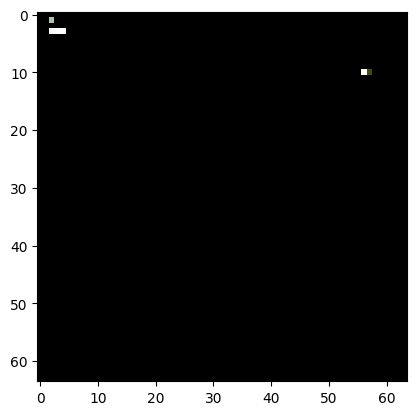

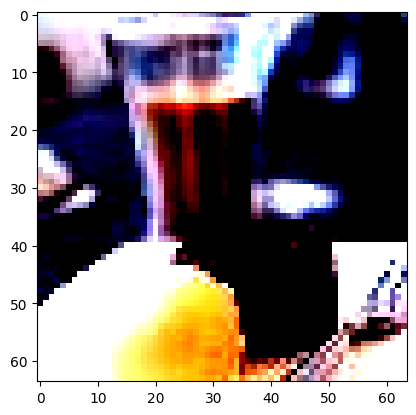

In [58]:
for batch in val_dataloader:
    images, class_nums = batch
    for i in range(18, 20):
      plt.imshow(images[i].permute(1, 2, 0))
      plt.show()
    break

## Задача 1.

Для того чтобы выбить скор (считается ниже) на 2.5/5 балла (то есть половину за задание) достаточно соблюдать пару простых жизненных правил:
1. Аугментация (без нее сложно очень будет)
2. Оптимайзеры можно (и нужно) использовать друг с другом. Однако когда что-то проверяете, то не меняйте несколько параметров сразу - собьете логику экспериментов
3. Не используйте полносвязные модели или самые первые сверточные, используйте более современные архитектуры (что на лекциях встречались)
4. Посмотреть все ноутбуки прошедших семинаров и слепить из них что-то общее. Семинарских тетрадок хватит сверх

### Модель (или просто импортируйте не предобученную)

In [ ]:
class YourNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # YOUR CODE HERE
        pass

    def _forward(self, x):
        # runs the Neural Network
        # YOUR CODE HERE
        pass

    def forward(self, images, target=None):
        # YOUR CODE HERE
        pass

    def get_accuracy(self, reset=False):
        # YOUR CODE HERE
        pass

### Тренировочный класс lightning

In [ ]:
class YourModule(pl.LightningModule):
    def __init__(self, model, learning_rate):
        super().__init__()
        # YOUR CODE HERE
        pass

    def forward(self, x):
        # YOUR CODE HERE
        pass

    def configure_optimizers(self):
        # YOUR CODE HERE
        pass

    def training_step(self, train_batch, batch_idx):
        # YOUR CODE HERE
        pass

    def validation_step(self, val_batch, batch_idx):
        # YOUR CODE HERE
        pass

In [ ]:
wandb_logger = WandbLogger(log_model='all') # какие возможности дает с pytorch_lightning https://docs.wandb.ai/guides/integrations/lightning
device = # YOUR CODE HERE

model = YourNet().to() # YOUR CODE HERE
module = YourModule() # YOUR CODE HERE

In [ ]:
trainer = pl.Trainer(logger=wandb_logger)  # YOUR CODE HERE
trainer.fit()  # YOUR CODE HERE

### Валидация результатов задания

In [ ]:
def evaluate_task(model, test_dataloader, device="cuda:0"):
    model = model.to(device)
    model.eval()
    accuracy = 0.0
    for images, labels in tqdm(test_dataloader):
        images, labels = images.to(device), labels.to(device)
        with torch.no_grad():
            loss = model(images, labels)
            acc_batch = model.get_accuracy(reset=True)
        accuracy += acc_batch
    accuracy = accuracy / len(test_dataloader)
    return accuracy

In [ ]:
model = # Подгрузить свою сохраненную модель сюда

accuracy = evaluate_task(model, val_dataloader)
print(f"Оценка за это задание составит {np.clip(10 * accuracy / 0.44, 0, 10):.2f} баллов")

## Задача 2

5 баллов
Добейтесь accuracy на валидации не менее 0.84. В этом задании делать ресайз и использовать претрейн можно.

Для того чтобы выбить скор (считается ниже) на 2.5/5 балла (то есть половину за задание) достаточно соблюдать пару простых жизненных правил:
1. Аугментация (без нее сложно очень будет)
2. Оптимайзеры можно (и нужно) использовать друг с другом. Однако когда что-то проверяете, то не меняйте несколько параметров сразу - собьете логику экспериментов
3. Не используйте полносвязные модели или самые первые сверточные, используйте более современные архитектуры (что на лекциях встречались или можете пойти дальше).
4. Попробуйте сначала посмотреть качество исходной модели без дообучения, сохраните как baseline. Отсюда поймете какие слои нужно дообучать.
5. Посмотреть все ноутбуки прошедших семинаров и слепить из них что-то общее. Семинарских тетрадок хватит сверх

### Модель (или просто импортируйте предобученную)

In [ ]:
class YourNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # YOUR CODE HERE
        pass

    def _forward(self, x):
        # runs the Neural Network
        # YOUR CODE HERE
        pass

    def forward(self, images, target=None):
        # YOUR CODE HERE
        pass

    def get_accuracy(self, reset=False):
        # YOUR CODE HERE
        pass

### Тренировочный класс lightning

In [ ]:
class YourModule(pl.LightningModule):
    def __init__(self, model, learning_rate):
        super().__init__()
        # YOUR CODE HERE
        pass

    def forward(self, x):
        # YOUR CODE HERE
        pass

    def configure_optimizers(self):
        # YOUR CODE HERE
        pass

    def training_step(self, train_batch, batch_idx):
        # YOUR CODE HERE
        pass

    def validation_step(self, val_batch, batch_idx):
        # YOUR CODE HERE
        pass

In [ ]:
wandb_logger = WandbLogger(log_model='all') # какие возможности дает с pytorch_lightning https://docs.wandb.ai/guides/integrations/lightning
device =  # YOUR CODE HERE

model = YourNet().to() # YOUR CODE HERE
module = YourModule() # YOUR CODE HERE

In [ ]:
trainer = pl.Trainer(logger=wandb_logger)  # YOUR CODE HERE
trainer.fit()  # YOUR CODE HERE

### Валидация результатов задания

In [ ]:
model = # Подгрузить свою сохраненную модель сюда

accuracy = evaluate_task(model, val_dataloader)
print(f"Оценка за это задание составит {np.clip(10 * (accuracy - 0.5) / 0.34, 0, 10):.2f} баллов")